## Identifying Maternal Health Care Deserts 
Anna E. Feldman | INFO 615, Spring/Summer 2024 Final Project
#### Analyzing Maternity Care Access in the United States at the County and Regional Level
#####  Source: U.S. Health Resources and Services Administration (HRSA), Area Health Resources Files, 2021, https://data.hrsa.gov/data/download  
##### Source: Census file for GeoDataframes spatial analysis: https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html
##### Data Dictionary: https://docs.google.com/spreadsheets/d/1Ob8zlireW9yoXKFDFGQKg6iWxViKjRGvQHfKSk3C-bU/edit#gid=0 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import contextily as cx
import geopandas as gpd
import shapely
from pointpats import centrography

### Read in file and describe characteristics

In [2]:
url="/Users/annafeldman/Desktop/afeldma7_final_files/AHRF_CSVandDocu/ahrf2023.csv"
df = pd.read_csv(url, encoding='latin-1')
df.head()
# Encoding latin-1 // DtypeWarning: Columns (14,16,24) have mixed types - need to specify

/var/folders/sf/whvty1j57cxcxs3t3mhwbcgh0000gn/T/ipykernel_60149/663894424.py:2: DtypeWarning: Columns (14,16,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(url, encoding='latin-1')


,blank,fips_st_cnty,entity_file,secndry_entity_file,date_file,date_cretn,file_length,st_name,st_name_abbrev,cnty_name,...,dys_air_qulty_mesrd_21,dys_mesrd_air_qulty_good_22,dys_mesrd_air_qulty_good_21,good_air_qulty_dys_pct_22,good_air_qulty_dys_pct_21,annul_partclt_mattr_2_5_avg_19,annul_partclt_mattr_2_5_avg_18,dys_8_hr_ozone_over_naaqs_avg_19,dys_8_hr_ozone_over_naaqs_avg_18,elevtn_feet_76
0,NaN,1001,AHRF,1001,2023,23208,25907,Alabama,AL,Autauga,...,NaN,NaN,NaN,NaN,NaN,10.0,9.5,1.0,0.0,290.0
1,NaN,1003,AHRF,1003,2023,23208,25907,Alabama,AL,Baldwin,...,280.0,256.0,264.0,91.1,94.29,7.6,7.2,0.0,0.0,155.0
2,NaN,1005,AHRF,1005,2023,23208,25907,Alabama,AL,Barbour,...,NaN,NaN,NaN,NaN,NaN,9.4,9.0,0.0,0.0,220.0
3,NaN,1007,AHRF,1007,2023,23208,25907,Alabama,AL,Bibb,...,NaN,NaN,NaN,NaN,NaN,9.8,9.4,0.0,1.0,224.0
4,NaN,1009,AHRF,1009,2023,23208,25907,Alabama,AL,Blount,...,NaN,NaN,NaN,NaN,NaN,9.6,9.4,1.0,1.0,870.0


#### Show size and column names
4306 Columns, 3231 rows with header row

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3231 entries, 0 to 3230
Columns: 4306 entries, blank to elevtn_feet_76
dtypes: float64(4286), int64(9), object(11)
memory usage: 106.1+ MB


In [4]:
df.columns

Index(['blank', 'fips_st_cnty', 'entity_file', 'secndry_entity_file',
       'date_file', 'date_cretn', 'file_length', 'st_name', 'st_name_abbrev',
       'cnty_name',
       ...
       'dys_air_qulty_mesrd_21', 'dys_mesrd_air_qulty_good_22',
       'dys_mesrd_air_qulty_good_21', 'good_air_qulty_dys_pct_22',
       'good_air_qulty_dys_pct_21', 'annul_partclt_mattr_2_5_avg_19',
       'annul_partclt_mattr_2_5_avg_18', 'dys_8_hr_ozone_over_naaqs_avg_19',
       'dys_8_hr_ozone_over_naaqs_avg_18', 'elevtn_feet_76'],
      dtype='object', length=4306)

### Clean data: create subset with targeted variables (df_new), remove territories and fully NaN columns
Now, make a new dataframe (df_new) with only the identified "target" 197 variables, down from 4036. (Go through Technical Documentation csv to find all variables related to numbers of OB-GYNs, hospitals with OB care, women's health centers, neonatal care, midwives, pediatrics, plus Census geographic data, insurance coverage rates per pop, demographic data on age / population.)

In [5]:
select_cols = ['st_name','st_name_abbrev','cnty_name', 'cnty_name_st_abbrev','fips_st','fips_st_cnty','fips_cnty',
               'cens_regn','cens_regn_name','cens_divsn','cens_divsn_name','fed_regn','metro_divsn_20',
               'metro_divsn_name_20','rural_urban_contnm_13','urban_influnc_13','popn_est_22',
               'popn_est_21','popn_21','popn_mal_21','popn_fem_21', 'popn_mal_15_19_20',
               'popn_mal_15_19_10','popn_fem_15_19_20','popn_fem_15_19_10','popn_mal_20_24_20',
               'popn_mal_20_24_10', 'popn_fem_20_24_20','popn_fem_20_24_10','popn_mal_25_29_20',
               'popn_mal_25_29_10', 'popn_fem_25_29_20','popn_fem_25_29_10','popn_mal_30_34_20',
               'popn_mal_30_34_10', 'popn_fem_30_34_20','popn_fem_30_34_10','popn_mal_35_44_20', 
               'popn_mal_35_44_10','popn_fem_35_44_20','popn_fem_35_44_10','medn_age_20','medn_age_10',
               'medn_age_mal_20', 'medn_age_mal_10','medn_age_fem_20','medn_age_fem_10','md_nf_obgyn_gen_21',
               'apn_midwvs_npi_21','hosp_21','stgh_obstetrc_care_21','stgh_neonat_icu_21','stgh_neonat_interm_care_21',
               'stgh_fertlty_clinc_21','sth_natal_postprtm_psych_svc_21','stgh_womns_hlth_ctr_svc_21',
               'stgh_obstetrcs_care_beds_21','stgh_neonat_icu_beds_21','stgh_neonat_interm_care_beds_21',
               'births_july_1_june_30_21','births_stgh_excl_fetal_deth_21','per_cap_persnl_incom_21','persnl_inc_21',
               'hhld_inc_lt10k_21','hhld_inc_10_14k_21','medn_famly_incom_21','pers_povty_21',
               'pers_povty_pct_21','pers_povty_pct_20','pers_18_64_20','pers_18_64_19', 'pers_ins_18_64_20',
               'pers_ins_18_64_19','pers_noins_18_64_20','pers_noins_18_64_19','pers_noins_18_64_pct_20','pers_noins_18_64_pct_19',
               'mal_18_64_20','mal_18_64_19','ins_mal_18_64_20','ins_mal_18_64_19','noins_mal_18_64_20','noins_mal_18_64_19',
               'noins_mal_18_64_pct_20','noins_mal_18_64_pct_19','fem_18_64_20','fem_18_64_19','ins_fem_18_64_20',
               'ins_fem_18_64_19','noins_fem_18_64_20','noins_fem_18_64_19','noins_fem_18_64_pct_20','noins_fem_18_64_pct_19',
               'stgh_birth_postprtm_rm_21', 'md_nf_ped_gen_21','contgs_cnty_num01' , 'contgs_cnty_num02', 'contgs_cnty_num03',
               'contgs_cnty_num04', 'contgs_cnty_num05', 'contgs_cnty_num06', 'contgs_cnty_num07', 'contgs_cnty_num08',
               'contgs_cnty_num09', 'contgs_cnty_num10', 'contgs_cnty_num11', 'contgs_cnty_num12', 'contgs_cnty_num13', 
               'contgs_cnty_num14']

In [6]:
df_new = df[select_cols]
df_new.head()
#109 columns now

,st_name,st_name_abbrev,cnty_name,cnty_name_st_abbrev,fips_st,fips_st_cnty,fips_cnty,cens_regn,cens_regn_name,cens_divsn,...,contgs_cnty_num05,contgs_cnty_num06,contgs_cnty_num07,contgs_cnty_num08,contgs_cnty_num09,contgs_cnty_num10,contgs_cnty_num11,contgs_cnty_num12,contgs_cnty_num13,contgs_cnty_num14
0,Alabama,AL,Autauga,"Autauga, AL",1,1001,1,3,South,6.0,...,1047.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Alabama,AL,Baldwin,"Baldwin, AL",1,1003,3,3,South,6.0,...,12033.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Alabama,AL,Barbour,"Barbour, AL",1,1005,5,3,South,6.0,...,1113.0,13061.0,13239.0,13259.0,NaN,NaN,NaN,NaN,NaN,NaN
3,Alabama,AL,Bibb,"Bibb, AL",1,1007,7,3,South,6.0,...,1105.0,1065.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Alabama,AL,Blount,"Blount, AL",1,1009,9,3,South,6.0,...,1073.0,1127.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
#df_new.info()
df_new.columns

Index(['st_name', 'st_name_abbrev', 'cnty_name', 'cnty_name_st_abbrev',
       'fips_st', 'fips_st_cnty', 'fips_cnty', 'cens_regn', 'cens_regn_name',
       'cens_divsn',
       ...
       'contgs_cnty_num05', 'contgs_cnty_num06', 'contgs_cnty_num07',
       'contgs_cnty_num08', 'contgs_cnty_num09', 'contgs_cnty_num10',
       'contgs_cnty_num11', 'contgs_cnty_num12', 'contgs_cnty_num13',
       'contgs_cnty_num14'],
      dtype='object', length=109)

#### Ensure no columns have fully NaN vals and drop territories
Note that contiguous counties are float types and include NaN values instead of zeros - to be addressed later in analysis

In [8]:
#df_nonullcols = df.dropna(axis=1, how='all')
#df_nonullcols.head()
df_new = df_new.dropna(axis=1, how='all')
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3231 entries, 0 to 3230
Columns: 109 entries, st_name to contgs_cnty_num14
dtypes: float64(97), int64(5), object(7)
memory usage: 2.7+ MB


In [9]:
df_new = df_new[~((df_new['st_name_abbrev'] == 'VI') | (df_new['st_name_abbrev'] == 'PR')
                  | (df_new['st_name_abbrev'] == 'GU'))]

print(df_new)

      st_name st_name_abbrev   cnty_name cnty_name_st_abbrev  fips_st  \
0     Alabama             AL     Autauga         Autauga, AL        1   
1     Alabama             AL     Baldwin         Baldwin, AL        1   
2     Alabama             AL     Barbour         Barbour, AL        1   
3     Alabama             AL        Bibb            Bibb, AL        1   
4     Alabama             AL      Blount          Blount, AL        1   
...       ...            ...         ...                 ...      ...   
3144  Wyoming             WY  Sweetwater      Sweetwater, WY       56   
3145  Wyoming             WY       Teton           Teton, WY       56   
3146  Wyoming             WY       Uinta           Uinta, WY       56   
3147  Wyoming             WY    Washakie        Washakie, WY       56   
3148  Wyoming             WY      Weston          Weston, WY       56   

      fips_st_cnty  fips_cnty  cens_regn cens_regn_name  cens_divsn  ...  \
0             1001          1          3       

### Normalize variables by population(s) and add new variables
Drop NaNs from female population. In df_new, find number of OBGYNs per total population of women; number of Peds per number of Births; number of OBGYNs per number of Births; number of OBGYNs per 1000 females. https://www.cdc.gov/nchs/fastats/births.htm 

In [10]:
# 3149 rows in df_new, now remove NaNs from female population - to 3143 rows in filtered df
df_new = df_new.dropna(subset=['popn_fem_21'])
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3143 entries, 0 to 3148
Columns: 109 entries, st_name to contgs_cnty_num14
dtypes: float64(97), int64(5), object(7)
memory usage: 2.6+ MB


In [11]:
df_new['obs_per_fml']= df['md_nf_obgyn_gen_21'] / df['popn_fem_21']
df_new['obs_per_1K_fml'] = df_new['obs_per_fml'] * 1000
#a typical OB sees 20-40 patients per day, 3-4 days per week, or 1-2K total load

#df_new['percentobs_per_fml'] = df_new['obs_per_fml'] * 100

df_new['obs_per_birth']= df['md_nf_obgyn_gen_21'] / df['births_july_1_june_30_21']
df_new['obs_per_11_births']= df_new['obs_per_birth'] * 11
# about 10K births per day across entire United States
# Birth rate is 11.0 per 1,000 population (CDC)

df_new['peds_per_birth']= df['md_nf_ped_gen_21'] / df['births_july_1_june_30_21']
df_new[['st_name_abbrev','cnty_name','obs_per_fml','obs_per_1K_fml', 'obs_per_11_births', 'obs_per_birth','peds_per_birth',
        'md_nf_obgyn_gen_21','popn_fem_21','popn_21','md_nf_ped_gen_21','births_july_1_june_30_21']].head(20)

,st_name_abbrev,cnty_name,obs_per_fml,obs_per_1K_fml,obs_per_11_births,obs_per_birth,peds_per_birth,md_nf_obgyn_gen_21,popn_fem_21,popn_21,md_nf_ped_gen_21,births_july_1_june_30_21
0,AL,Autauga,0.000000,0.000000,0.000000,0.000000,0.001541,0.0,30362.0,59095.0,1.0,649.0
1,AL,Baldwin,0.000212,0.211602,0.126549,0.011504,0.011504,26.0,122872.0,239294.0,26.0,2260.0
2,AL,Barbour,0.000000,0.000000,0.000000,0.000000,0.003650,0.0,11659.0,24964.0,1.0,274.0
3,AL,Bibb,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,10343.0,22477.0,0.0,226.0
4,AL,Blount,0.000000,0.000000,0.000000,0.000000,0.003180,0.0,29634.0,59041.0,2.0,629.0
5,AL,Bullock,0.000000,0.000000,0.000000,0.000000,0.007692,0.0,4603.0,10320.0,1.0,130.0
6,AL,Butler,0.000000,0.000000,0.000000,0.000000,0.004673,0.0,10079.0,18884.0,1.0,214.0
7,AL,Calhoun,0.000200,0.200391,0.100000,0.009091,0.009848,12.0,59883.0,115972.0,13.0,1320.0
8,AL,Chambers,0.000000,0.000000,0.000000,0.000000,0.002809,0.0,17983.0,34541.0,1.0,356.0
9,AL,Cherokee,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,12558.0,24996.0,0.0,238.0


### EDA: Explore df_new full dataset, then create/explore separate rural and urban county dfs
Analyze patterns and outliers in the dataframe, e.g. on OBs per 1K females, OBs per birth rate, low % of OBs per population or other variables.

In [12]:
df_new[['popn_fem_21','md_nf_obgyn_gen_21', 'obs_per_1K_fml','st_name_abbrev','cnty_name', 'contgs_cnty_num01','contgs_cnty_num02']]

,popn_fem_21,md_nf_obgyn_gen_21,obs_per_1K_fml,st_name_abbrev,cnty_name,contgs_cnty_num01,contgs_cnty_num02
0,30362.0,0.0,0.000000,AL,Autauga,1021.0,1051.0
1,122872.0,26.0,0.211602,AL,Baldwin,1025.0,1053.0
2,11659.0,0.0,0.000000,AL,Barbour,1045.0,1067.0
3,10343.0,0.0,0.000000,AL,Bibb,1125.0,1073.0
4,29634.0,0.0,0.000000,AL,Blount,1043.0,1095.0
...,...,...,...,...,...,...,...
3144,20058.0,4.0,0.199422,WY,Sweetwater,56041.0,56023.0
3145,11247.0,7.0,0.622388,WY,Teton,16019.0,16043.0
3146,10106.0,1.0,0.098951,WY,Uinta,56023.0,56037.0
3147,3744.0,0.0,0.000000,WY,Washakie,56003.0,56019.0


#### EDA with df_new (all rural and urban counties) in 2021
Explore a couple of the data points, e.g. numbers of obgyns (general, total) in 2021: find that average number (12) much higher than median (1) number of OBs, and maximum is 1250 while almost all counties (75% of them) have 5 or less. This number becomes even smaller when viewing the rate per 1K females in the population, with the max Obs per 1K equal to less than 2. Observe lots of counties with 0 (zero) OB numbers, but have not removed counties with very low populations or other outliers or split off rural vs urban.

In [13]:
df_new[['md_nf_obgyn_gen_21', 'st_name', 'cnty_name', 'obs_per_1K_fml', 'rural_urban_contnm_13', 'urban_influnc_13']].head(35)

,md_nf_obgyn_gen_21,st_name,cnty_name,obs_per_1K_fml,rural_urban_contnm_13,urban_influnc_13
0,0.0,Alabama,Autauga,0.000000,2.0,2.0
1,26.0,Alabama,Baldwin,0.211602,3.0,2.0
2,0.0,Alabama,Barbour,0.000000,6.0,6.0
3,0.0,Alabama,Bibb,0.000000,1.0,1.0
4,0.0,Alabama,Blount,0.000000,1.0,1.0
5,0.0,Alabama,Bullock,0.000000,6.0,6.0
6,0.0,Alabama,Butler,0.000000,6.0,6.0
7,12.0,Alabama,Calhoun,0.200391,3.0,2.0
8,0.0,Alabama,Chambers,0.000000,6.0,5.0
9,0.0,Alabama,Cherokee,0.000000,6.0,6.0


In [14]:
# Descriptive stats on total numbers of OBs in 2021?
df_new['md_nf_obgyn_gen_21'].describe()

count    3143.000000
mean       12.769647
std        52.115352
min         0.000000
25%         0.000000
50%         1.000000
75%         5.000000
max      1250.000000
Name: md_nf_obgyn_gen_21, dtype: float64

In [15]:
# Descriptive stats on numbers of OBs per 1K female population in 2021?
df_new['obs_per_1K_fml'].describe()

count    3143.000000
mean        0.099950
std         0.144925
min         0.000000
25%         0.000000
50%         0.035569
75%         0.164526
max         1.777413
Name: obs_per_1K_fml, dtype: float64

In [16]:
#What is the obgyn total number per county, segmented by state?
df_new.groupby('st_name')['md_nf_obgyn_gen_21'].sum().sort_values()

st_name
Wyoming                57.0
North Dakota           75.0
South Dakota           82.0
Alaska                 90.0
Vermont               100.0
Montana               104.0
Delaware              115.0
Idaho                 135.0
Maine                 156.0
New Hampshire         172.0
West Virginia         181.0
Rhode Island          192.0
Dist. of Columbia     215.0
Nebraska              216.0
New Mexico            220.0
Iowa                  221.0
Hawaii                227.0
Arkansas              259.0
Nevada                287.0
Kansas                295.0
Oklahoma              304.0
Mississippi           304.0
Utah                  311.0
Kentucky              455.0
Alabama               503.0
Oregon                556.0
Wisconsin             601.0
South Carolina        603.0
Indiana               663.0
Connecticut           672.0
Minnesota             687.0
Missouri              710.0
Louisiana             714.0
Arizona               728.0
Colorado              739.0
Washington  

In [17]:
#What is the obgyn total number per county, segmented by state?
df_new.groupby('st_name')['md_nf_obgyn_gen_21'].sum().sort_values()

st_name
Wyoming                57.0
North Dakota           75.0
South Dakota           82.0
Alaska                 90.0
Vermont               100.0
Montana               104.0
Delaware              115.0
Idaho                 135.0
Maine                 156.0
New Hampshire         172.0
West Virginia         181.0
Rhode Island          192.0
Dist. of Columbia     215.0
Nebraska              216.0
New Mexico            220.0
Iowa                  221.0
Hawaii                227.0
Arkansas              259.0
Nevada                287.0
Kansas                295.0
Oklahoma              304.0
Mississippi           304.0
Utah                  311.0
Kentucky              455.0
Alabama               503.0
Oregon                556.0
Wisconsin             601.0
South Carolina        603.0
Indiana               663.0
Connecticut           672.0
Minnesota             687.0
Missouri              710.0
Louisiana             714.0
Arizona               728.0
Colorado              739.0
Washington  

In [18]:
#What is the obgyn total number per county, segmented by rural urban continuum?
df_new.groupby('rural_urban_contnm_13')['md_nf_obgyn_gen_21'].sum().sort_values()

rural_urban_contnm_13
8.0       31.0
9.0       33.0
7.0      446.0
5.0      506.0
6.0      560.0
4.0      818.0
3.0     2910.0
2.0     8354.0
1.0    26477.0
Name: md_nf_obgyn_gen_21, dtype: float64

In [19]:
#What is the obgyn total number per county across all rural and metro, segmented by state?
df_new.groupby('st_name')['obs_per_1K_fml'].sum().sort_values()

st_name
Delaware              0.560558
Dist. of Columbia     0.612281
Hawaii                0.943995
Rhode Island          1.566390
Arizona               1.739737
North Dakota          2.019926
Connecticut           2.065123
Alaska                2.194624
Nevada                2.244808
Utah                  2.354812
New Hampshire         2.450499
Idaho                 2.638394
Maine                 2.702433
New Mexico            3.049724
Nebraska              3.170039
Vermont               3.192134
Wyoming               3.396553
Massachusetts         3.434474
Washington            3.843707
Oklahoma              4.078053
Maryland              4.385931
New Jersey            4.564010
Kansas                4.642183
South Dakota          4.824999
Iowa                  4.895505
Arkansas              4.992567
Montana               4.998869
West Virginia         5.136198
Alabama               5.397552
South Carolina        5.697561
Oregon                6.203050
Wisconsin             7.133923


#### EDA with Metro (and adjacent to metro) v Non-metro (and rural)
948 counties are "true" rural, while 2195 are metro or adjacent metro counties. Numbers look skewed to metro areas, but actually look fairly similar when standardized by female population.

In [20]:
#rural and non-adjacent separate analysis: where code = 5,7, or 9 (metro or adjacent to = 1,2,3,4,6,8)

df_rural = df_new[((df_new['rural_urban_contnm_13'] == 5.0) | (df_new['rural_urban_contnm_13'] == 7.0) | 
                   (df_new['rural_urban_contnm_13'] == 9.0))]

df_metro = df_new[~((df_new['rural_urban_contnm_13'] == 5.0) | (df_new['rural_urban_contnm_13'] == 7.0) | 
                    (df_new['rural_urban_contnm_13'] == 9.0))]

In [21]:
df_rural['md_nf_obgyn_gen_21'].describe()

count    948.000000
mean       1.039030
std        2.422518
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max       33.000000
Name: md_nf_obgyn_gen_21, dtype: float64

In [22]:
df_metro['md_nf_obgyn_gen_21'].describe()

count    2195.000000
mean       17.835991
std        61.659491
min         0.000000
25%         0.000000
50%         2.000000
75%         9.000000
max      1250.000000
Name: md_nf_obgyn_gen_21, dtype: float64

In [23]:
df_rural['obs_per_1K_fml'].describe()

count    948.000000
mean       0.065982
std        0.122843
min        0.000000
25%        0.000000
50%        0.000000
75%        0.112053
max        1.042209
Name: obs_per_1K_fml, dtype: float64

In [24]:
df_metro['obs_per_1K_fml'].describe()

count    2195.000000
mean        0.114621
std         0.151166
min         0.000000
25%         0.000000
50%         0.079086
75%         0.177289
max         1.777413
Name: obs_per_1K_fml, dtype: float64

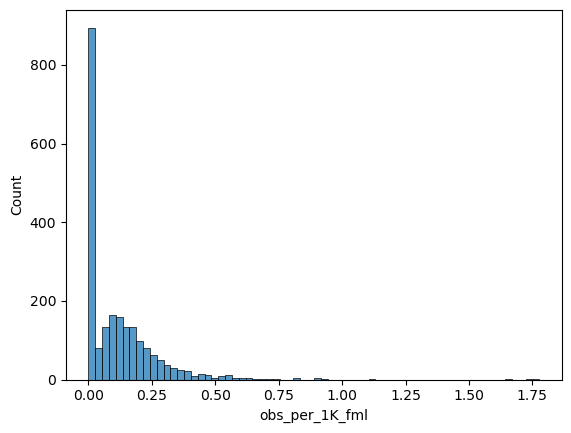

In [25]:
sns.histplot(data=df_metro, x='obs_per_1K_fml'); 

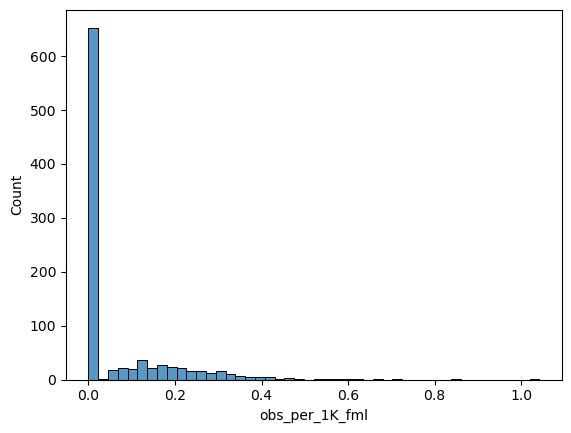

In [26]:
sns.histplot(data=df_rural, x='obs_per_1K_fml'); 

In [27]:
zero_obs_rural = df_rural[(df_rural['obs_per_1K_fml'] == 0)] #separate out the zeros
zero_obs_metro = df_metro[(df_metro['obs_per_1K_fml'] == 0)] #separate out the zeros

In [190]:
zero_obs = df_new[(df_new['obs_per_1K_fml'] == 0)]
zero_obs['obs_per_fml'].describe()

count    1531.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: obs_per_fml, dtype: float64

In [28]:
zero_obs_rural['obs_per_fml'].describe()
#653 counties with zero OBs still

count    653.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: obs_per_fml, dtype: float64

In [29]:
zero_obs_metro['obs_per_fml'].describe()
#878 metro counties with zero

count    878.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: obs_per_fml, dtype: float64

#### Explore # of OBs per 1000 female population and segmented by state

In [30]:
df_new['obs_per_1K_fml'].describe()
# maximum number, 1.8 - still very low numbers for 75% or more of pop

count    3143.000000
mean        0.099950
std         0.144925
min         0.000000
25%         0.000000
50%         0.035569
75%         0.164526
max         1.777413
Name: obs_per_1K_fml, dtype: float64

In [31]:
# highest and lowest female populations
df_sorted_fmls = df_new.groupby('st_name')['popn_fem_21'].sum().sort_values()
df_sorted_fmls

st_name
Wyoming                282589.0
Vermont                324720.0
Alaska                 348469.0
Dist. of Columbia      351146.0
North Dakota           376539.0
South Dakota           440534.0
Delaware               516048.0
Montana                545001.0
Rhode Island           558649.0
Maine                  695754.0
New Hampshire          695860.0
Hawaii                 716220.0
West Virginia          893861.0
Idaho                  942307.0
Nebraska               976900.0
New Mexico            1063180.0
Kansas                1464091.0
Mississippi           1514629.0
Arkansas              1532713.0
Nevada                1559894.0
Iowa                  1591695.0
Utah                  1647906.0
Connecticut           1836010.0
Oklahoma              2002339.0
Oregon                2129317.0
Kentucky              2275505.0
Louisiana             2358856.0
Alabama               2591778.0
South Carolina        2666990.0
Minnesota             2846977.0
Colorado              2867419.0


In [36]:
#OBs per 1000 females, sorted
df_sorted_OBsperfml = df_new.groupby('st_name')['obs_per_1K_fml'].sum().sort_values()
df_sorted_OBsperfml

st_name
Delaware              0.560558
Dist. of Columbia     0.612281
Hawaii                0.943995
Rhode Island          1.566390
Arizona               1.739737
North Dakota          2.019926
Connecticut           2.065123
Alaska                2.194624
Nevada                2.244808
Utah                  2.354812
New Hampshire         2.450499
Idaho                 2.638394
Maine                 2.702433
New Mexico            3.049724
Nebraska              3.170039
Vermont               3.192134
Wyoming               3.396553
Massachusetts         3.434474
Washington            3.843707
Oklahoma              4.078053
Maryland              4.385931
New Jersey            4.564010
Kansas                4.642183
South Dakota          4.824999
Iowa                  4.895505
Arkansas              4.992567
Montana               4.998869
West Virginia         5.136198
Alabama               5.397552
South Carolina        5.697561
Oregon                6.203050
Wisconsin             7.133923


In [37]:
#What is the obgyn per 1k female number, segmented both by state and county?
obsperfml_sorted_stcntys = df_new.groupby(['st_name','cnty_name','popn_est_21'])['obs_per_1K_fml'].sum()
obsperfml_sorted_stcntys 
#seems to have some interesting outliers? patterns = higher pops, higher OBs, but what about places where that is not true? 
#e.g. Wyoming, in Teton vs Sweetwater rates vs population

st_name  cnty_name   popn_est_21
Alabama  Autauga     59095.0        0.000000
         Baldwin     239294.0       0.211602
         Barbour     24964.0        0.000000
         Bibb        22477.0        0.000000
         Blount      59041.0        0.000000
                                      ...   
Wyoming  Sweetwater  41614.0        0.199422
         Teton       23575.0        0.622388
         Uinta       20635.0        0.098951
         Washakie    7705.0         0.000000
         Weston      6745.0         0.000000
Name: obs_per_1K_fml, Length: 3143, dtype: float64

### Create geodataframe for mapping / spatial analysis called gdf_new
#### Spatial autocorrelation with polygons
Join counties in df_new to geographic polygons for geodataframe analysis (gdf_new), using either county or congressional boundary files (gdf_counties). Split rural/urban with gdf_rural, gdf_metro. Source of GeoDataframes for spatial analysis: https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html

In [195]:
#gdf_counties_new = gpd.read_file('/Users/annafeldman/Desktop/2020_Gaz_counties_national.csv')
gdf_counties = gpd.read_file('/Users/annafeldman/Desktop/Final Project things/county_census/cb_2018_us_county_500k.shp')
#gdf_counties_congress = gpd.read_file('/Users/annafeldman/Desktop/Final Project things/county_census/county_congressdistricts_census/cb_2018_us_county_within_cd116_500k.shp')

In [196]:
gdf_counties.head(45) #shows county name and fips

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,21,007,00516850,0500000US21007,21007,Ballard,06,639387454,69473325,"POLYGON ((-89.18137 37.04630, -89.17938 37.053..."
1,21,017,00516855,0500000US21017,21017,Bourbon,06,750439351,4829777,"POLYGON ((-84.44266 38.28324, -84.44114 38.283..."
2,21,031,00516862,0500000US21031,21031,Butler,06,1103571974,13943044,"POLYGON ((-86.94486 37.07341, -86.94346 37.074..."
3,21,065,00516879,0500000US21065,21065,Estill,06,655509930,6516335,"POLYGON ((-84.12662 37.64540, -84.12483 37.646..."
4,21,069,00516881,0500000US21069,21069,Fleming,06,902727151,7182793,"POLYGON ((-83.98428 38.44549, -83.98246 38.450..."
5,21,093,00516893,0500000US21093,21093,Hardin,06,1614569777,17463238,"POLYGON ((-86.27756 37.58881, -86.27420 37.589..."
6,21,099,00516896,0500000US21099,21099,Hart,06,1068530028,13692536,"POLYGON ((-86.16112 37.35080, -86.15845 37.351..."
7,21,131,00516912,0500000US21131,21131,Leslie,06,1038206077,9189732,"POLYGON ((-83.55310 37.07928, -83.53528 37.103..."
8,21,151,00516919,0500000US21151,21151,Madison,06,1132729653,15306635,"POLYGON ((-84.52564 37.76950, -84.52350 37.771..."
9,21,155,00516921,0500000US21155,21155,Marion,06,888463701,9891797,"POLYGON ((-85.52129 37.55434, -85.50452 37.584..."


In [197]:
#add square miles 
gdf_counties['LandArea_SqMiles']= gdf_counties['ALAND']/2589988
gdf_counties.head(20)

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,LandArea_SqMiles
0,21,007,00516850,0500000US21007,21007,Ballard,06,639387454,69473325,"POLYGON ((-89.18137 37.04630, -89.17938 37.053...",246.868887
1,21,017,00516855,0500000US21017,21017,Bourbon,06,750439351,4829777,"POLYGON ((-84.44266 38.28324, -84.44114 38.283...",289.746266
2,21,031,00516862,0500000US21031,21031,Butler,06,1103571974,13943044,"POLYGON ((-86.94486 37.07341, -86.94346 37.074...",426.091539
3,21,065,00516879,0500000US21065,21065,Estill,06,655509930,6516335,"POLYGON ((-84.12662 37.64540, -84.12483 37.646...",253.093810
4,21,069,00516881,0500000US21069,21069,Fleming,06,902727151,7182793,"POLYGON ((-83.98428 38.44549, -83.98246 38.450...",348.544916
5,21,093,00516893,0500000US21093,21093,Hardin,06,1614569777,17463238,"POLYGON ((-86.27756 37.58881, -86.27420 37.589...",623.388903
6,21,099,00516896,0500000US21099,21099,Hart,06,1068530028,13692536,"POLYGON ((-86.16112 37.35080, -86.15845 37.351...",412.561768
7,21,131,00516912,0500000US21131,21131,Leslie,06,1038206077,9189732,"POLYGON ((-83.55310 37.07928, -83.53528 37.103...",400.853624
8,21,151,00516919,0500000US21151,21151,Madison,06,1132729653,15306635,"POLYGON ((-84.52564 37.76950, -84.52350 37.771...",437.349383
9,21,155,00516921,0500000US21155,21155,Marion,06,888463701,9891797,"POLYGON ((-85.52129 37.55434, -85.50452 37.584...",343.037767


In [198]:
move_cols = gdf_counties.pop('LandArea_SqMiles')

# Insert the last column at the desired position (e.g., index 1)
gdf_counties.insert(7, 'LandArea_SqMiles', move_cols)

# Check the new column order
print(gdf_counties.columns)

Index(['STATEFP', 'COUNTYFP', 'COUNTYNS', 'AFFGEOID', 'GEOID', 'NAME', 'LSAD',
       'LandArea_SqMiles', 'ALAND', 'AWATER', 'geometry'],
      dtype='object')


#### Create new column concatenating state fips and county fips codes before joining to health data
df_new already has a concatenated state-city variable to use for joining

In [199]:
gdf_counties['state_cty_fips'] = gdf_counties['STATEFP'] + gdf_counties['COUNTYFP']

move_cols2 = gdf_counties.pop('state_cty_fips')
gdf_counties.insert(7, 'state_cty_fips', move_cols2)

gdf_counties.head(10)

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,state_cty_fips,LandArea_SqMiles,ALAND,AWATER,geometry
0,21,007,00516850,0500000US21007,21007,Ballard,06,21007,246.868887,639387454,69473325,"POLYGON ((-89.18137 37.04630, -89.17938 37.053..."
1,21,017,00516855,0500000US21017,21017,Bourbon,06,21017,289.746266,750439351,4829777,"POLYGON ((-84.44266 38.28324, -84.44114 38.283..."
2,21,031,00516862,0500000US21031,21031,Butler,06,21031,426.091539,1103571974,13943044,"POLYGON ((-86.94486 37.07341, -86.94346 37.074..."
3,21,065,00516879,0500000US21065,21065,Estill,06,21065,253.093810,655509930,6516335,"POLYGON ((-84.12662 37.64540, -84.12483 37.646..."
4,21,069,00516881,0500000US21069,21069,Fleming,06,21069,348.544916,902727151,7182793,"POLYGON ((-83.98428 38.44549, -83.98246 38.450..."
5,21,093,00516893,0500000US21093,21093,Hardin,06,21093,623.388903,1614569777,17463238,"POLYGON ((-86.27756 37.58881, -86.27420 37.589..."
6,21,099,00516896,0500000US21099,21099,Hart,06,21099,412.561768,1068530028,13692536,"POLYGON ((-86.16112 37.35080, -86.15845 37.351..."
7,21,131,00516912,0500000US21131,21131,Leslie,06,21131,400.853624,1038206077,9189732,"POLYGON ((-83.55310 37.07928, -83.53528 37.103..."
8,21,151,00516919,0500000US21151,21151,Madison,06,21151,437.349383,1132729653,15306635,"POLYGON ((-84.52564 37.76950, -84.52350 37.771..."
9,21,155,00516921,0500000US21155,21155,Marion,06,21155,343.037767,888463701,9891797,"POLYGON ((-85.52129 37.55434, -85.50452 37.584..."


In [200]:
#df_new['fips_st_cnty'].head()
df_new.head()

,st_name,st_name_abbrev,cnty_name,cnty_name_st_abbrev,fips_st,fips_st_cnty,fips_cnty,cens_regn,cens_regn_name,cens_divsn,...,contgs_cnty_num10,contgs_cnty_num11,contgs_cnty_num12,contgs_cnty_num13,contgs_cnty_num14,obs_per_fml,obs_per_1K_fml,obs_per_birth,obs_per_11_births,peds_per_birth
0,Alabama,AL,Autauga,"Autauga, AL",1,1001,1,3,South,6.0,...,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.001541
1,Alabama,AL,Baldwin,"Baldwin, AL",1,1003,3,3,South,6.0,...,NaN,NaN,NaN,NaN,NaN,0.000212,0.211602,0.011504,0.126549,0.011504
2,Alabama,AL,Barbour,"Barbour, AL",1,1005,5,3,South,6.0,...,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.003650
3,Alabama,AL,Bibb,"Bibb, AL",1,1007,7,3,South,6.0,...,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000
4,Alabama,AL,Blount,"Blount, AL",1,1009,9,3,South,6.0,...,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.003180


#### Map/view the original gdf_counties geodataframe 

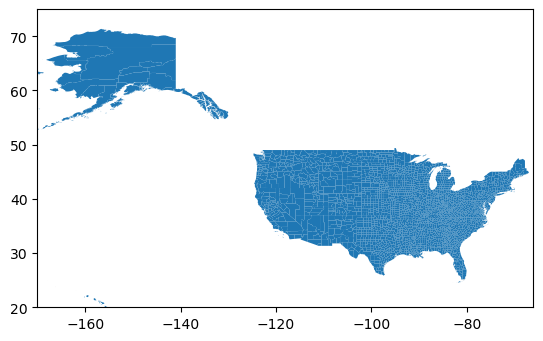

In [201]:
gdf_counties.plot()
#set axis limits (x_min, x_max, y_min, y_max)
plt.xlim(-170, -66)
plt.ylim(20, 75)

plt.show()

#### Join gdf_counties to dfs for gdf_new (all counties); gdf_new_metro; gdf_new_rural
gdf_counties contains county shapefile data; df dataframe contains FIPS state and county codes

In [202]:
gdf_counties['state_cty_fips'].dtype #object
df_new['fips_st_cnty'].dtype #int

dtype('int64')

In [203]:
# Convert new col in gdf_counties to integer
gdf_counties['state_cty_fips'] = gdf_counties['state_cty_fips'].astype(int)
gdf_counties['state_cty_fips'].dtype

dtype('int64')

In [204]:
# Merge gdf and df based on FIPS state and county code variable
gdf_new = gpd.GeoDataFrame(pd.merge(df_new, gdf_counties, how='inner', 
                                      right_on=['state_cty_fips'], left_on=['fips_st_cnty']))
gdf_new.head()

,st_name,st_name_abbrev,cnty_name,cnty_name_st_abbrev,fips_st,fips_st_cnty,fips_cnty,cens_regn,cens_regn_name,cens_divsn,...,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,state_cty_fips,LandArea_SqMiles,ALAND,AWATER,geometry
0,Alabama,AL,Autauga,"Autauga, AL",1,1001,1,3,South,6.0,...,00161526,0500000US01001,01001,Autauga,06,1001,594.443728,1539602123,25706961,"POLYGON ((-86.92120 32.65754, -86.92035 32.658..."
1,Alabama,AL,Baldwin,"Baldwin, AL",1,1003,3,3,South,6.0,...,00161527,0500000US01003,01003,Baldwin,06,1003,1589.793727,4117546676,1133055836,"POLYGON ((-88.02858 30.22676, -88.02399 30.230..."
2,Alabama,AL,Barbour,"Barbour, AL",1,1005,5,3,South,6.0,...,00161528,0500000US01005,01005,Barbour,06,1005,885.002037,2292144655,50538698,"POLYGON ((-85.74803 31.61918, -85.74544 31.618..."
3,Alabama,AL,Bibb,"Bibb, AL",1,1007,7,3,South,6.0,...,00161529,0500000US01007,01007,Bibb,06,1007,622.461371,1612167481,9602089,"POLYGON ((-87.42194 33.00338, -87.31854 33.006..."
4,Alabama,AL,Blount,"Blount, AL",1,1009,9,3,South,6.0,...,00161530,0500000US01009,01009,Blount,06,1009,644.830752,1670103911,15015423,"POLYGON ((-86.96336 33.85822, -86.95967 33.857..."


In [205]:
# Merge gdf and rural df based on FIPS state and county code variable
gdf_rural = gpd.GeoDataFrame(pd.merge(df_rural, gdf_counties, how='inner', 
                                      right_on=['state_cty_fips'], left_on=['fips_st_cnty']))

In [206]:
# Merge gdf and metro df based on FIPS state and county code variable
gdf_metro = gpd.GeoDataFrame(pd.merge(df_metro, gdf_counties, how='inner', 
                                      right_on=['state_cty_fips'], left_on=['fips_st_cnty']))

In [207]:
gdf_new.info() 

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3141 entries, 0 to 3140
Columns: 126 entries, st_name to geometry
dtypes: float64(103), geometry(1), int64(8), object(14)
memory usage: 3.0+ MB


In [208]:
gdf_rural.info() 

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 948 entries, 0 to 947
Columns: 126 entries, st_name to geometry
dtypes: float64(103), geometry(1), int64(8), object(14)
memory usage: 933.3+ KB


In [209]:
gdf_metro.info() 

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2193 entries, 0 to 2192
Columns: 126 entries, st_name to geometry
dtypes: float64(103), geometry(1), int64(8), object(14)
memory usage: 2.1+ MB


### Create new metric analyzing OB numbers and rates including contiguous counties.
The loop iterates through each of the contiguous county columns (contgs_cnty_num01 to contgs_cnty_num14).
For each row in the DataFrame, it checks whether a contiguous county exists and adds land area condition to focus on counties that are, in theory, navigable in a long commute (2 hours, 120 miles) or less.
It then finds the matching FIPS code, retrieves the corresponding md_nf_ped_gen_21 value, and adds it to contig_obs_sum for the original row. 

In [210]:
#create a variable to add together all contiguous county numbers: contig_obs_sum

#df_new = df_new.reset_index(drop=True)
gdf_new['contig_obs_sum'] = 0 
#set all values to zero to start
gdf_new['contig_obs_sum'] = gdf_new['md_nf_obgyn_gen_21'] + gdf_new['contig_obs_sum']
#set all values to current county value
gdf_new[['st_name_abbrev','cnty_name','md_nf_obgyn_gen_21','contig_obs_sum','LandArea_SqMiles',
         'contgs_cnty_num01', 'contgs_cnty_num02', 
         'contgs_cnty_num03']].head(25)

#next: add results to the variable from for loop, otherwise keeps to the same number as the original value

,st_name_abbrev,cnty_name,md_nf_obgyn_gen_21,contig_obs_sum,LandArea_SqMiles,contgs_cnty_num01,contgs_cnty_num02,contgs_cnty_num03
0,AL,Autauga,0.0,0.0,594.443728,1021.0,1051.0,1101.0
1,AL,Baldwin,26.0,26.0,1589.793727,1025.0,1053.0,1097.0
2,AL,Barbour,0.0,0.0,885.002037,1045.0,1067.0,1011.0
3,AL,Bibb,0.0,0.0,622.461371,1125.0,1073.0,1021.0
4,AL,Blount,0.0,0.0,644.830752,1043.0,1095.0,1055.0
5,AL,Bullock,0.0,0.0,622.805650,1101.0,1087.0,1113.0
6,AL,Butler,0.0,0.0,776.838553,1131.0,1085.0,1041.0
7,AL,Calhoun,12.0,12.0,605.867526,1055.0,1019.0,1029.0
8,AL,Chambers,0.0,0.0,596.560913,1081.0,1123.0,1111.0
9,AL,Cherokee,0.0,0.0,553.525082,1049.0,1055.0,1015.0


In [211]:
for i in range(1, 15):  # loops through numbers 1 to 14
    
    #need to loop through column names 'contgs_cnty_num01', 'contgs_cnty_num02', etc.
    column_name = f'contgs_cnty_num{i:02d}'
    #print(column_name) #works here!
    gdf_new[column_name] = gdf_new[column_name].fillna(0) #make all NaNs zero
    
    for index, row in gdf_new.iterrows():
        
        if row[column_name] !=0 and row['LandArea_SqMiles'] < 1000.00:
    
            #get fips code of contiguous county, store fips in temp variable
            temp_fips = int(row[column_name])
            #print(temp_fips)
    
            # get the match: where a row's fips code value is equal to temp_fips 
            # temp_fips_row is the row number where the temp_fips is located in the gdf 
            temp_fips_row = gdf_new.loc[gdf_new['fips_st_cnty'] == temp_fips].index
            #print(temp_fips_row) #is a series
            
            if len(temp_fips_row) > 0: #if the row exists in the gdf
                temp_fips_index = temp_fips_row[0]  #get the row number where the fips located
                value = gdf_new.at[temp_fips_index, 'fips_st_cnty']
                #print(value) #value is the fips code too
                
                temp_obs = gdf_new.at[temp_fips_index, 'md_nf_obgyn_gen_21']
                #look up a row where the matched index is and get the 'md_nf_obgyn_gen_21' value
                #temp OBs is the number of OBs at the row identified for this contiguous county
                #print(temp_obs) 
    
                #add this to original number
                gdf_new.at[index, 'contig_obs_sum'] += temp_obs
            
            else:
                temp_fips_index = None  #the row does not exist in the gdf
                continue
            
            #print(temp_fips_index) # check that it works and returns correct matching row
                
            #keep summing the OB numbers/looping

#check e.g. if temp_fips_row is 726, fips should be 17153. gdf_new.loc[726] 

In [212]:
gdf_new[['st_name_abbrev','cnty_name','md_nf_obgyn_gen_21', 'contig_obs_sum', 'LandArea_SqMiles', 'GEOID',
         'contgs_cnty_num01', 'contgs_cnty_num02', 'contgs_cnty_num03','contgs_cnty_num04', 
        'contgs_cnty_num05', 'contgs_cnty_num06','contgs_cnty_num07', 'contgs_cnty_num08', 'contgs_cnty_num09',
        'contgs_cnty_num10','contgs_cnty_num11', 'contgs_cnty_num12', 'contgs_cnty_num13', 'contgs_cnty_num14']].head(35)

,st_name_abbrev,cnty_name,md_nf_obgyn_gen_21,contig_obs_sum,LandArea_SqMiles,GEOID,contgs_cnty_num01,contgs_cnty_num02,contgs_cnty_num03,contgs_cnty_num04,contgs_cnty_num05,contgs_cnty_num06,contgs_cnty_num07,contgs_cnty_num08,contgs_cnty_num09,contgs_cnty_num10,contgs_cnty_num11,contgs_cnty_num12,contgs_cnty_num13,contgs_cnty_num14
0,AL,Autauga,0.0,30.0,594.443728,01001,1021.0,1051.0,1101.0,1085.0,1047.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,AL,Baldwin,26.0,26.0,1589.793727,01003,1025.0,1053.0,1097.0,1099.0,12033.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,AL,Barbour,0.0,5.0,885.002037,01005,1045.0,1067.0,1011.0,1109.0,1113.0,13061.0,13239.0,13259.0,0.0,0.0,0.0,0.0,0.0,0.0
3,AL,Bibb,0.0,208.0,622.461371,01007,1125.0,1073.0,1021.0,1117.0,1105.0,1065.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,AL,Blount,0.0,183.0,644.830752,01009,1043.0,1095.0,1055.0,1115.0,1073.0,1127.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,AL,Bullock,0.0,27.0,622.805650,01011,1101.0,1087.0,1113.0,1005.0,1109.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,AL,Butler,0.0,2.0,776.838553,01013,1131.0,1085.0,1041.0,1039.0,1035.0,1099.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,AL,Calhoun,12.0,17.0,605.867526,01015,1055.0,1019.0,1029.0,1121.0,1115.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,AL,Chambers,0.0,25.0,596.560913,01017,1081.0,1123.0,1111.0,13149.0,13285.0,13145.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,AL,Cherokee,0.0,34.0,553.525082,01019,1049.0,1055.0,1015.0,1029.0,13115.0,13055.0,13233.0,13295.0,0.0,0.0,0.0,0.0,0.0,0.0


#### testing - checks logic with specific row look-ups

In [213]:
gdf_new.loc[34, ['GEOID', 'md_nf_obgyn_gen_21']] #check - works

GEOID                 01069
md_nf_obgyn_gen_21     18.0
Name: 34, dtype: object

In [214]:
gdf_new.loc[621, ['GEOID', 'md_nf_obgyn_gen_21']] #check - match

GEOID                 17055
md_nf_obgyn_gen_21      0.0
Name: 621, dtype: object

In [215]:
check = gdf_new.loc[df['md_nf_obgyn_gen_21'] == 184.0]
#check returns the df 
check[['GEOID', 'md_nf_ped_gen_21']]

,GEOID,md_nf_ped_gen_21
621,17055,0.0
1153,22083,1.0


In [216]:
# check for Pittsburg, OK; Teeole, UT

In [217]:
#specific_row_values = gdf_new.loc[gdf_new['md_nf_ped_gen_21'] == 1217, ['GEOID', 'md_nf_ped_gen_21']]
specific_row_values = gdf_new.loc[gdf_new['fips_st_cnty'] == 40121, ['GEOID', 'contig_obs_sum', 'LandArea_SqMiles',
                                                                     'cnty_name','md_nf_obgyn_gen_21','contgs_cnty_num01']]
#check returns the correct df

print(specific_row_values)

      GEOID  contig_obs_sum  LandArea_SqMiles  cnty_name  md_nf_obgyn_gen_21  \
2190  40121             4.0       1305.459892  Pittsburg                 4.0   

      contgs_cnty_num01  
2190            40063.0  


#### Use values from new metric for spatial analysis; divide into rural/metro gdfs for separate analyses
gdf_new is full data; gdf_rural and gdf_metro are respective subsets. total_ob_access_per_fml is the ob #s plus contiguous county #s. total_ob_access_per_1K_fml is this number per 1k female pop.

In [218]:
#use new variable total_ob_access, the total OB #s with contiguous counties included 
#instead of md_nf_obgyn variable, use new metric: 
#gdf_new['contig_obs_sum'] which includes gdf_new['md_nf_ped_gen_21'] + gdf_new['contig_obs_sum']

gdf_new['total_ob_access_per_fml']= gdf_new['contig_obs_sum'] / gdf_new['popn_fem_21']
gdf_new['total_ob_access_per_1K_fml'] = gdf_new['total_ob_access_per_fml'] * 1000
gdf_new['total_ob_access_per_birth']= gdf_new['contig_obs_sum'] / gdf_new['births_july_1_june_30_21']
gdf_new['total_ob_access_per_11_births']= gdf_new['total_ob_access_per_birth'] * 11

gdf_new[['st_name_abbrev','cnty_name','contig_obs_sum','md_nf_obgyn_gen_21','obs_per_fml','obs_per_1K_fml',
        'total_ob_access_per_fml','total_ob_access_per_1K_fml', 'total_ob_access_per_birth','total_ob_access_per_11_births',
        'popn_fem_21','popn_21','births_july_1_june_30_21']].head(20)

,st_name_abbrev,cnty_name,contig_obs_sum,md_nf_obgyn_gen_21,obs_per_fml,obs_per_1K_fml,total_ob_access_per_fml,total_ob_access_per_1K_fml,total_ob_access_per_birth,total_ob_access_per_11_births,popn_fem_21,popn_21,births_july_1_june_30_21
0,AL,Autauga,30.0,0.0,0.000000,0.000000,0.000988,0.988077,0.046225,0.508475,30362.0,59095.0,649.0
1,AL,Baldwin,26.0,26.0,0.000212,0.211602,0.000212,0.211602,0.011504,0.126549,122872.0,239294.0,2260.0
2,AL,Barbour,5.0,0.0,0.000000,0.000000,0.000429,0.428853,0.018248,0.200730,11659.0,24964.0,274.0
3,AL,Bibb,208.0,0.0,0.000000,0.000000,0.020110,20.110219,0.920354,10.123894,10343.0,22477.0,226.0
4,AL,Blount,183.0,0.0,0.000000,0.000000,0.006175,6.175339,0.290938,3.200318,29634.0,59041.0,629.0
5,AL,Bullock,27.0,0.0,0.000000,0.000000,0.005866,5.865740,0.207692,2.284615,4603.0,10320.0,130.0
6,AL,Butler,2.0,0.0,0.000000,0.000000,0.000198,0.198432,0.009346,0.102804,10079.0,18884.0,214.0
7,AL,Calhoun,17.0,12.0,0.000200,0.200391,0.000284,0.283887,0.012879,0.141667,59883.0,115972.0,1320.0
8,AL,Chambers,25.0,0.0,0.000000,0.000000,0.001390,1.390202,0.070225,0.772472,17983.0,34541.0,356.0
9,AL,Cherokee,34.0,0.0,0.000000,0.000000,0.002707,2.707437,0.142857,1.571429,12558.0,24996.0,238.0


In [219]:
#create separate analysis rural and non-adjacent to metro: code = 5,7, or 9
#if metro or adjacent to metro, code= 1,2,3,4,6,8

gdf_rural = gdf_new[((gdf_new['rural_urban_contnm_13'] == 5.0) | (gdf_new['rural_urban_contnm_13'] == 7.0) | 
                   (gdf_new['rural_urban_contnm_13'] == 9.0))]

gdf_metro = gdf_new[~((gdf_new['rural_urban_contnm_13'] == 5.0) | (gdf_new['rural_urban_contnm_13'] == 7.0) | 
                    (gdf_new['rural_urban_contnm_13'] == 9.0))]

In [220]:
gdf_rural[['st_name_abbrev','cnty_name','obs_per_fml','obs_per_1K_fml', 'contig_obs_sum','md_nf_obgyn_gen_21',
        'total_ob_access_per_fml','total_ob_access_per_1K_fml', 'total_ob_access_per_birth','total_ob_access_per_11_births',
        'popn_fem_21','popn_21','births_july_1_june_30_21']].head(10)

,st_name_abbrev,cnty_name,obs_per_fml,obs_per_1K_fml,contig_obs_sum,md_nf_obgyn_gen_21,total_ob_access_per_fml,total_ob_access_per_1K_fml,total_ob_access_per_birth,total_ob_access_per_11_births,popn_fem_21,popn_21,births_july_1_june_30_21
11,AL,Choctaw,0.0,0.0,9.0,0.0,0.001370,1.370280,0.062500,0.687500,6568.0,12533.0,144.0
12,AL,Clarke,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,11934.0,22760.0,287.0
13,AL,Clay,0.0,0.0,7.0,0.0,0.000971,0.970739,0.049645,0.546099,7211.0,14190.0,141.0
17,AL,Conecuh,0.0,0.0,4.0,0.0,0.000681,0.681431,0.029197,0.321168,5870.0,11328.0,137.0
45,AL,Marengo,0.0,0.0,5.0,0.0,0.000498,0.497711,0.022222,0.244444,10046.0,18996.0,225.0
46,AL,Marion,0.0,0.0,13.0,0.0,0.000890,0.890289,0.040373,0.444099,14602.0,29246.0,322.0
49,AL,Monroe,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,10239.0,19648.0,232.0
65,AL,Wilcox,0.0,0.0,5.0,0.0,0.000904,0.904486,0.034722,0.381944,5528.0,10446.0,144.0
67,AK,Aleutians East (B),0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1121.0,3398.0,14.0
68,AK,Aleutians West (CA),0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1649.0,5059.0,29.0


In [221]:
gdf_metro[['st_name_abbrev','cnty_name','obs_per_fml','obs_per_1K_fml','md_nf_obgyn_gen_21',
        'total_ob_access_per_fml','total_ob_access_per_1K_fml', 'total_ob_access_per_birth','total_ob_access_per_11_births',
        'popn_fem_21','popn_21','births_july_1_june_30_21']].head(10)

,st_name_abbrev,cnty_name,obs_per_fml,obs_per_1K_fml,md_nf_obgyn_gen_21,total_ob_access_per_fml,total_ob_access_per_1K_fml,total_ob_access_per_birth,total_ob_access_per_11_births,popn_fem_21,popn_21,births_july_1_june_30_21
0,AL,Autauga,0.000000,0.000000,0.0,0.000988,0.988077,0.046225,0.508475,30362.0,59095.0,649.0
1,AL,Baldwin,0.000212,0.211602,26.0,0.000212,0.211602,0.011504,0.126549,122872.0,239294.0,2260.0
2,AL,Barbour,0.000000,0.000000,0.0,0.000429,0.428853,0.018248,0.200730,11659.0,24964.0,274.0
3,AL,Bibb,0.000000,0.000000,0.0,0.020110,20.110219,0.920354,10.123894,10343.0,22477.0,226.0
4,AL,Blount,0.000000,0.000000,0.0,0.006175,6.175339,0.290938,3.200318,29634.0,59041.0,629.0
5,AL,Bullock,0.000000,0.000000,0.0,0.005866,5.865740,0.207692,2.284615,4603.0,10320.0,130.0
6,AL,Butler,0.000000,0.000000,0.0,0.000198,0.198432,0.009346,0.102804,10079.0,18884.0,214.0
7,AL,Calhoun,0.000200,0.200391,12.0,0.000284,0.283887,0.012879,0.141667,59883.0,115972.0,1320.0
8,AL,Chambers,0.000000,0.000000,0.0,0.001390,1.390202,0.070225,0.772472,17983.0,34541.0,356.0
9,AL,Cherokee,0.000000,0.000000,0.0,0.002707,2.707437,0.142857,1.571429,12558.0,24996.0,238.0


#### how do the numbers change overall? how do rural and metro county zero-access numbers change?

In [224]:
zero_obs_gdf = gdf_new[(gdf_new['total_ob_access_per_fml'] == 0)] 
zero_obs_rural_gdf = gdf_rural[(gdf_rural['total_ob_access_per_fml'] == 0)] #separate out the zeros
zero_obs_metro_gdf = gdf_metro[(gdf_metro['total_ob_access_per_fml'] == 0)] #separate out the zeros

In [225]:
zero_obs_gdf['contig_obs_sum'].describe()

count    426.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: contig_obs_sum, dtype: float64

In [226]:
zero_obs_metro_gdf['contig_obs_sum'].describe()

count    139.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: contig_obs_sum, dtype: float64

In [227]:
zero_obs_rural_gdf['contig_obs_sum'].describe()

count    287.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: contig_obs_sum, dtype: float64

### Mapping original metrics
Most counties have zero OBs - want to look at neighbors and see if they are clustered together, e.g. if there is spatial autocorrelation in gdfs.

#### basic map without data

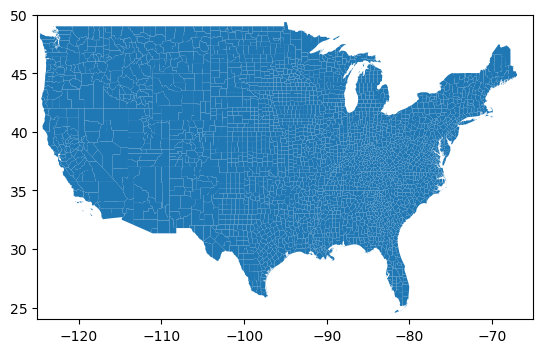

In [60]:
gdf_new.plot()
#set axis limits (x_min, x_max, y_min, y_max)
plt.xlim(-125, -65)
plt.ylim(24, 50)
plt.show()

#### Mapping original (normalized) metrics: Map of percent OBs per female pop of 1000

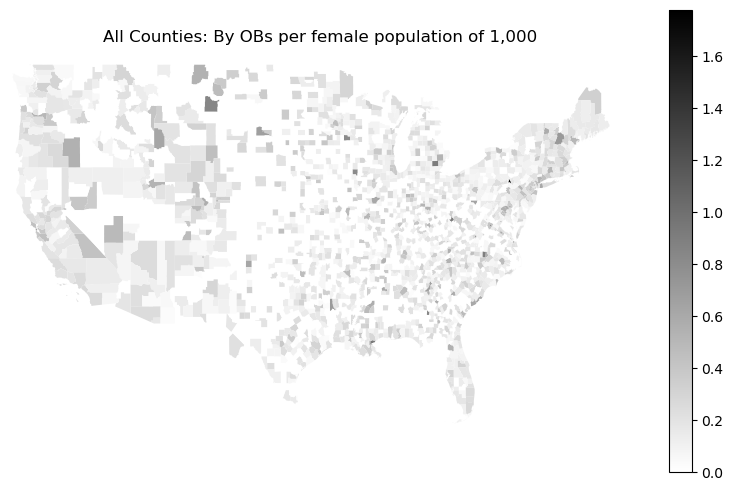

In [232]:
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust figsize as needed
gdf_new.plot(column='obs_per_1K_fml', cmap='binary', ax=ax, legend=True)

# Add title and labels
plt.title('All Counties: By OBs per female population of 1,000')

#set axis limits (x_min, x_max, y_min, y_max)
plt.xlim(-125, -65)
plt.ylim(24, 50)
ax.axis('off')

plt.show()

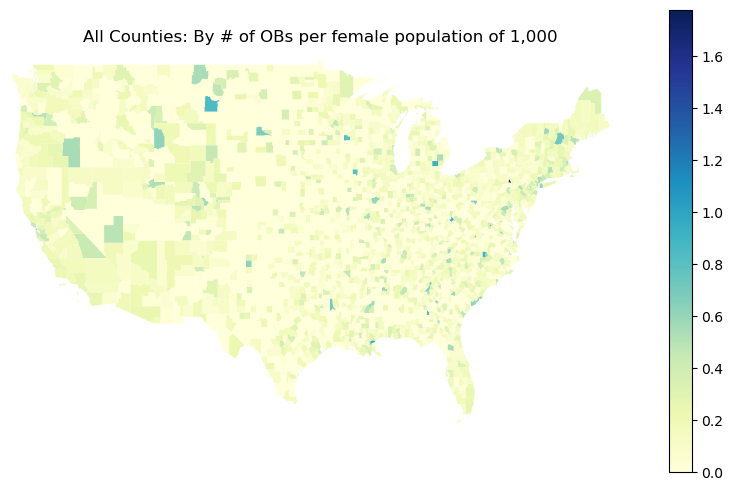

In [230]:
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust figsize as needed
gdf_new.plot(column='obs_per_1K_fml', cmap='YlGnBu', ax=ax, legend=True)

# Add title and labels
plt.title('All Counties: By # of OBs per female population of 1,000')

#set axis limits (x_min, x_max, y_min, y_max)
plt.xlim(-125, -65)
plt.ylim(24, 50)
ax.axis('off')

plt.show();

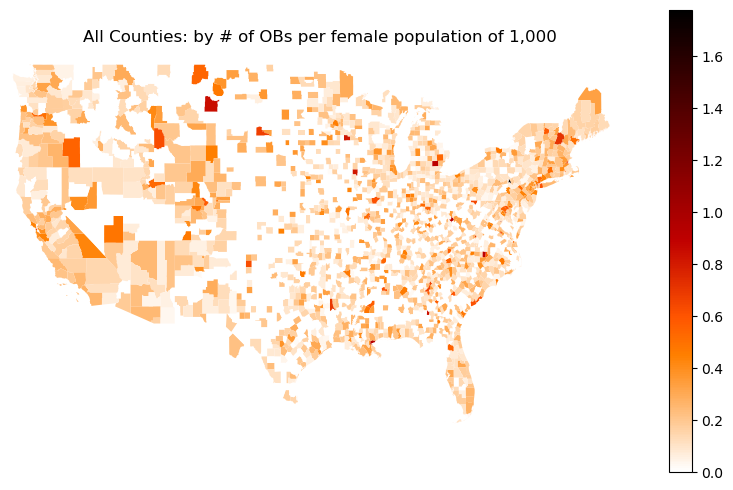

In [238]:
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust figsize as needed

gdf_new.plot(column='obs_per_1K_fml', cmap='gist_heat_r', ax=ax, legend=True)

# Add title and labels
plt.title('All Counties: by # of OBs per female population of 1,000')

#set axis limits (x_min, x_max, y_min, y_max)
plt.xlim(-125, -65)
plt.ylim(24, 50)
ax.axis('off')

plt.show();

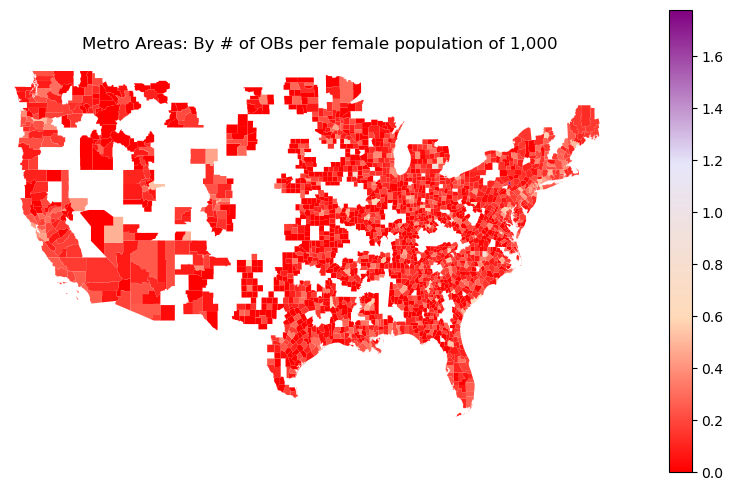

In [236]:
from matplotlib.colors import LinearSegmentedColormap

fig, ax = plt.subplots(figsize=(10, 6))  # Adjust figsize as needed

colors= ["red", "#FFDAB9", "lavender", "purple"]
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)
gdf_metro.plot(column='obs_per_1K_fml', cmap=cmap, ax=ax, legend=True)
#gdf_metro.plot(column='obs_per_1K_fml', cmap='gist_heat_r', ax=ax, legend=True)

# Add title and labels
plt.title('Metro Areas: By # of OBs per female population of 1,000')

#set axis limits (x_min, x_max, y_min, y_max)
plt.xlim(-125, -65)
plt.ylim(24, 50)
ax.axis('off')

plt.show();

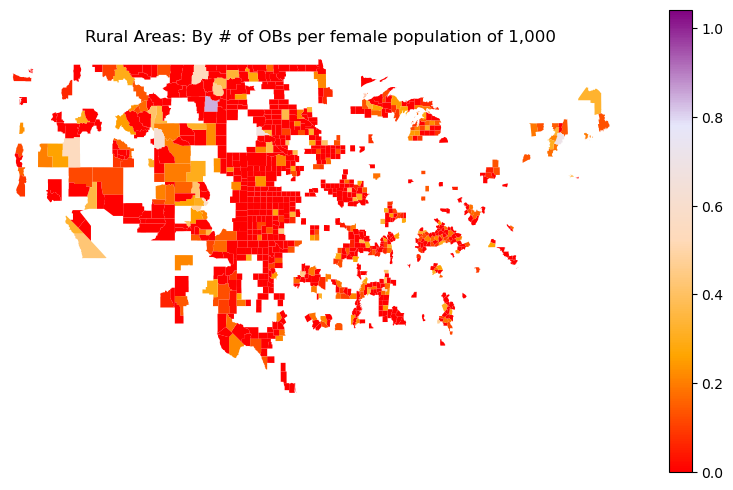

In [237]:
colors= ["red", "orange","#FFDAB9", "lavender", "purple"]
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

fig, ax = plt.subplots(figsize=(10, 6))  # Adjust figsize as needed
gdf_rural.plot(column='obs_per_1K_fml', cmap=cmap, ax=ax, legend=True)

# Add title and labels
plt.title('Rural Areas: By # of OBs per female population of 1,000')

#set axis limits (x_min, x_max, y_min, y_max)
plt.xlim(-125, -65)
plt.ylim(24, 50)
ax.axis('off')

plt.show();

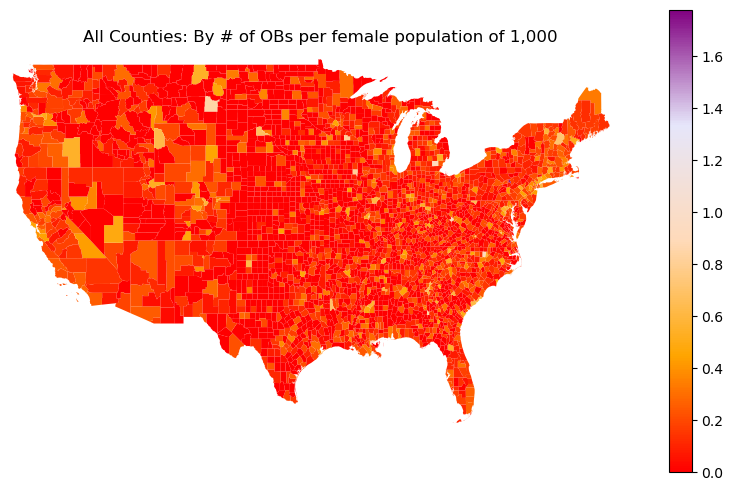

In [173]:
colors= ["red", "orange","#FFDAB9", "lavender", "purple"]
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

fig, ax = plt.subplots(figsize=(10, 6))  # Adjust figsize as needed
gdf_new.plot(column='obs_per_1K_fml', cmap=cmap, ax=ax, legend=True)

# Add title and labels
plt.title('All Counties: By # of OBs per female population of 1,000')

#set axis limits (x_min, x_max, y_min, y_max)
plt.xlim(-125, -65)
plt.ylim(24, 50)
ax.axis('off')

plt.show();

#### Mapping new metric: OBs per 1K females PLUS contiguous counties

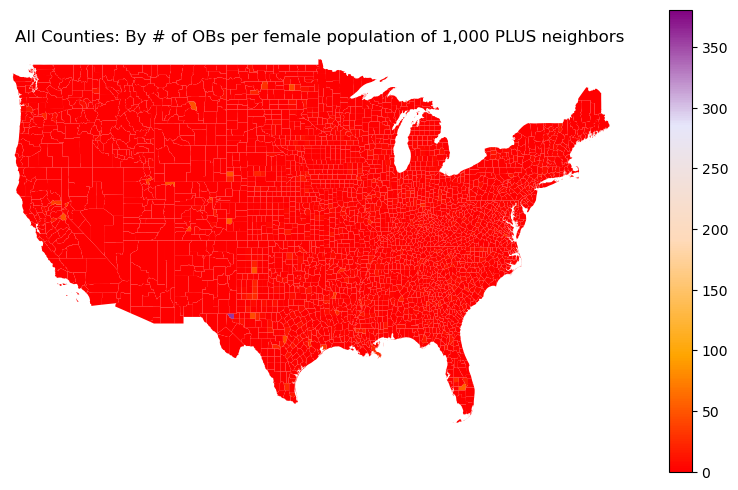

In [174]:
colors= ["red", "orange","#FFDAB9", "lavender", "purple"]
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

fig, ax = plt.subplots(figsize=(10, 6))  # Adjust figsize as needed
gdf_new.plot(column='total_ob_access_per_1K_fml', cmap=cmap, ax=ax, legend=True)

# Add title and labels
plt.title('All Counties: By # of OBs per female population of 1,000 PLUS neighbors')

#set axis limits (x_min, x_max, y_min, y_max)
plt.xlim(-125, -65)
plt.ylim(24, 50)
ax.axis('off')

plt.show();

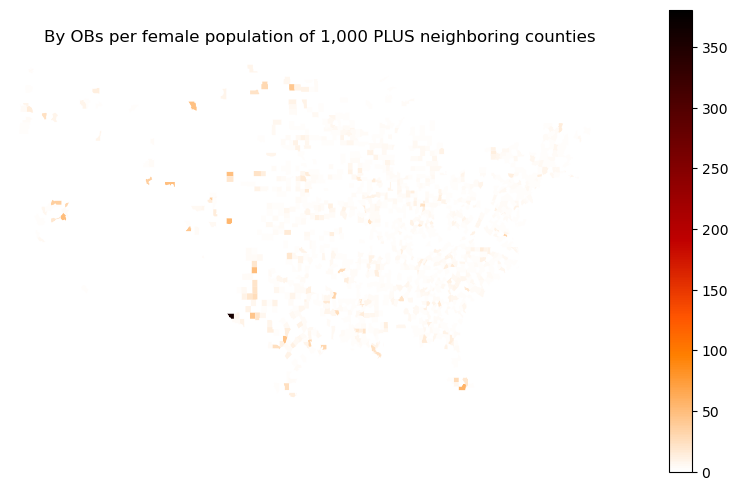

In [239]:
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust figsize as needed
gdf_new.plot(column='total_ob_access_per_1K_fml', cmap='gist_heat_r', ax=ax, legend=True)

# Add title and labels
plt.title('By OBs per female population of 1,000 PLUS neighboring counties')

#set axis limits (x_min, x_max, y_min, y_max)
plt.xlim(-125, -65)
plt.ylim(24, 50)
ax.axis('off')

plt.show()

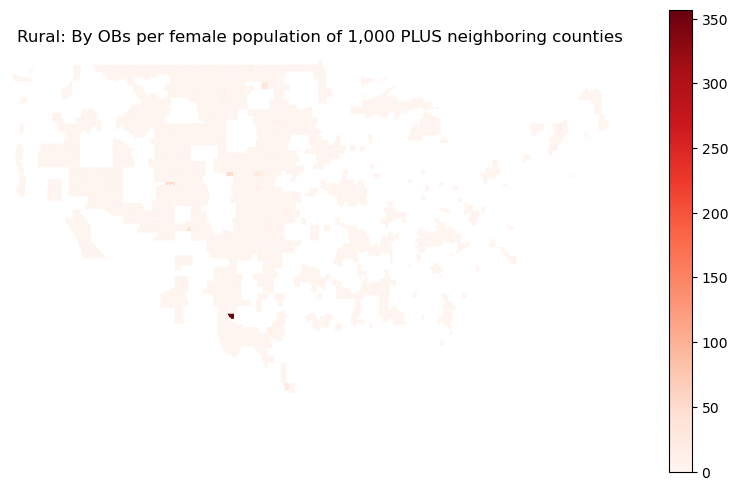

In [246]:
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust figsize as needed
gdf_rural.plot(column='total_ob_access_per_1K_fml', cmap='Reds', ax=ax, legend=True)

# Add title and labels
plt.title('Rural: By OBs per female population of 1,000 PLUS neighboring counties')

#set axis limits (x_min, x_max, y_min, y_max)
plt.xlim(-125, -65)
plt.ylim(24, 50)
ax.axis('off')

plt.show()

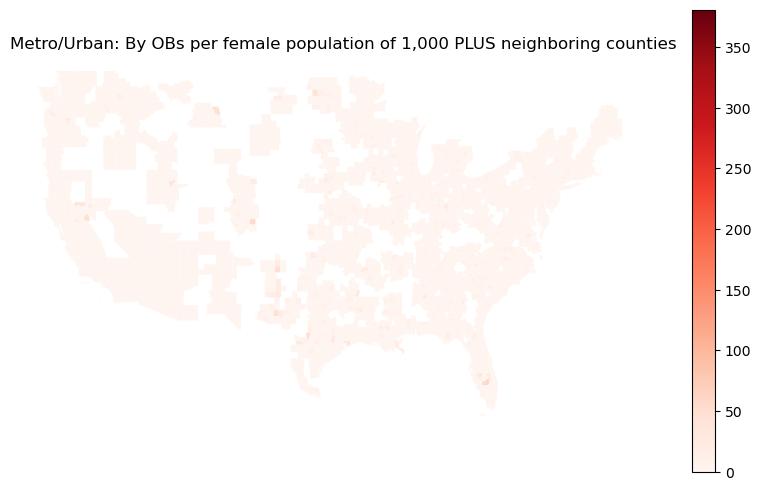

In [245]:
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust figsize as needed
gdf_metro.plot(column='total_ob_access_per_1K_fml', cmap='Reds', ax=ax, legend=True)

# Add title and labels
plt.title('Metro/Urban: By OBs per female population of 1,000 PLUS neighboring counties')

#set axis limits (x_min, x_max, y_min, y_max)
plt.xlim(-125, -65)
plt.ylim(24, 50)
ax.axis('off')

plt.show()

### Mapping Spatial Autocorrelation
#### Global/Local Moran's I for old and new metrics
Based on old metric (OBs / 1K females), there is positive spatial autocorrelation for the full counties dataset, gdf_new. Based on new metric, (OBs / 1K females but factoring in neighboring counties), there is likely no spatial autocorrelation and the distribution is random (global morans I's of 0.0034303165518536336 and p val of .1852). Same with the rural and metro gdfs.

#### Global Moran's I calculation for gdf_new based on OBs per 1000 females
Create a spatial weights matrix, which defines the spatial relationships between counties. Common choices include contiguity-based weights (e.g., Queen or Rook).

In [100]:
from pysal.lib import weights
from pysal.explore import esda

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/annafeldman/miniconda3/envs/new_info615/lib/python3.12/site-packages/spaghetti/network.py:42: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)


In [101]:
#generate weights with Queen contiguity
w = weights.Queen.from_dataframe(gdf_new)

/var/folders/sf/whvty1j57cxcxs3t3mhwbcgh0000gn/T/ipykernel_60149/2327017669.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = weights.Queen.from_dataframe(gdf_new)
/Users/annafeldman/miniconda3/envs/new_info615/lib/python3.12/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 11 disconnected components.
 There are 7 islands with ids: 68, 545, 546, 548, 1219, 1225, 2979.
  W.__init__(self, neighbors, ids=ids, **kw)


In [102]:
#RURAL - generate weights with Queen contiguity
w2 = weights.Queen.from_dataframe(gdf_rural)

/var/folders/sf/whvty1j57cxcxs3t3mhwbcgh0000gn/T/ipykernel_60149/863413502.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w2 = weights.Queen.from_dataframe(gdf_rural)
/Users/annafeldman/miniconda3/envs/new_info615/lib/python3.12/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 73 disconnected components.
 There are 40 islands with ids: 2, 9, 103, 121, 131, 132, 149, 150, 174, 177, 178, 216, 222, 343, 346, 348, 349, 366, 394, 445, 488, 614, 623, 632, 634, 674, 676, 677, 679, 722, 733, 734, 786, 901, 902, 903, 904, 905, 919, 923.
  W.__init__(self, neighbors, ids=ids, **kw)


In [103]:
#METRO/URBAN -generate weights with Queen contiguity
w3 = weights.Queen.from_dataframe(gdf_metro)

/var/folders/sf/whvty1j57cxcxs3t3mhwbcgh0000gn/T/ipykernel_60149/1736542656.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w3 = weights.Queen.from_dataframe(gdf_metro)
/Users/annafeldman/miniconda3/envs/new_info615/lib/python3.12/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 11 disconnected components.
 There is 1 island with id: 414.
  W.__init__(self, neighbors, ids=ids, **kw)


In [104]:
w.full()[0]
#shows the contiguous / neighbor counties 

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [105]:
#row standardize w
w.transform = 'R'

('WARNING: ', 68, ' is an island (no neighbors)')
('WARNING: ', 545, ' is an island (no neighbors)')
('WARNING: ', 546, ' is an island (no neighbors)')
('WARNING: ', 548, ' is an island (no neighbors)')
('WARNING: ', 1219, ' is an island (no neighbors)')
('WARNING: ', 1225, ' is an island (no neighbors)')
('WARNING: ', 2979, ' is an island (no neighbors)')


In [106]:
#row standardize w - RURAL
w2.transform = 'R'

('WARNING: ', 2, ' is an island (no neighbors)')
('WARNING: ', 9, ' is an island (no neighbors)')
('WARNING: ', 103, ' is an island (no neighbors)')
('WARNING: ', 121, ' is an island (no neighbors)')
('WARNING: ', 131, ' is an island (no neighbors)')
('WARNING: ', 132, ' is an island (no neighbors)')
('WARNING: ', 149, ' is an island (no neighbors)')
('WARNING: ', 150, ' is an island (no neighbors)')
('WARNING: ', 174, ' is an island (no neighbors)')
('WARNING: ', 177, ' is an island (no neighbors)')
('WARNING: ', 178, ' is an island (no neighbors)')
('WARNING: ', 216, ' is an island (no neighbors)')
('WARNING: ', 222, ' is an island (no neighbors)')
('WARNING: ', 343, ' is an island (no neighbors)')
('WARNING: ', 346, ' is an island (no neighbors)')
('WARNING: ', 348, ' is an island (no neighbors)')
('WARNING: ', 349, ' is an island (no neighbors)')
('WARNING: ', 366, ' is an island (no neighbors)')
('WARNING: ', 394, ' is an island (no neighbors)')
('WARNING: ', 445, ' is an island (

In [107]:
#row standardize w - METRO
w3.transform = 'R'

('WARNING: ', 414, ' is an island (no neighbors)')


In [108]:
moran = esda.moran.Moran(gdf_new['obs_per_1K_fml'], w, permutations=9999)

In [109]:
moran.I #positive spatial autocorrelation for gdf_new based on OBs/1k females

0.13937070452328967

In [110]:
moran.p_sim

0.0001

RESULTS: The very low p value of 0.0001 means that we should reject the null hypothesis that there is no spatial autocorrelation present. Spatial autocorrelation is present but we cannot conclude what shape it takes from this alone.

#### Global Moran's I calculation for gdf_new, gdf_rural, gdf_metro based on TOTAL OBs (in contiguous) per 1000 females
The Moran's I value close to zero, combined with a p_sim value of 0.1767, indicates that there is no significant spatial autocorrelation in the data. The observed spatial distribution is likely random, and there is no strong evidence of spatial clustering or dispersion.

In [111]:
moran = esda.moran.Moran(gdf_new['total_ob_access_per_1K_fml'], w, permutations=9999)

In [112]:
moran.I #changed!

0.0034303165518536336

In [113]:
moran.p_sim

0.1857

In [114]:
moran = esda.moran.Moran(gdf_rural['total_ob_access_per_1K_fml'], w2, permutations=9999)
moran.I # close to 0 - data shows no significant spatial autocorrelation, implies random spatial distribution.

-0.004962541685747583

In [115]:
moran.p_sim

0.2877

In [116]:
moran = esda.moran.Moran(gdf_metro['total_ob_access_per_1K_fml'], w3, permutations=9999)
moran.I # close to 0 - data shows no significant spatial autocorrelation, implies random spatial distribution.

-0.001363313255594668

In [117]:
moran.p_sim

0.4443

#### Local Moran's I Calculation and Map
Local spatial autocorrelation tells us the locations of where spatial autocorrelation occurs (a “local statistic”); to characterize and detect the individual locations of statistically significant hot spots, cold spots and outliers.

In [118]:
gdf_new.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

In [119]:
r = gdf_new
local_moran = esda.moran.Moran_Local(r['obs_per_1K_fml'], w)

In [120]:
r['local_moran_Is'] = local_moran.Is

In [121]:
r['local_moran_pvalue'] = local_moran.p_sim

In [122]:
r['local_moran_quadrant'] = local_moran.q

In [123]:
alpha = 0.05
hotspots = r.query(f"local_moran_pvalue < {alpha} & local_moran_quadrant == 1")
coldspots = r.query(f"local_moran_pvalue < {alpha} & local_moran_quadrant == 2")
doughnuts = r.query(f"local_moran_pvalue < {alpha} & local_moran_quadrant == 3")
diamonds = r.query(f"local_moran_pvalue < {alpha} & local_moran_quadrant == 4")

/Users/annafeldman/miniconda3/envs/new_info615/lib/python3.12/site-packages/mapclassify/classifiers.py:1592: UserWarning: Not enough unique values in array to form 5 classes. Setting k to 4.
  self.bins = quantile(y, k=k)


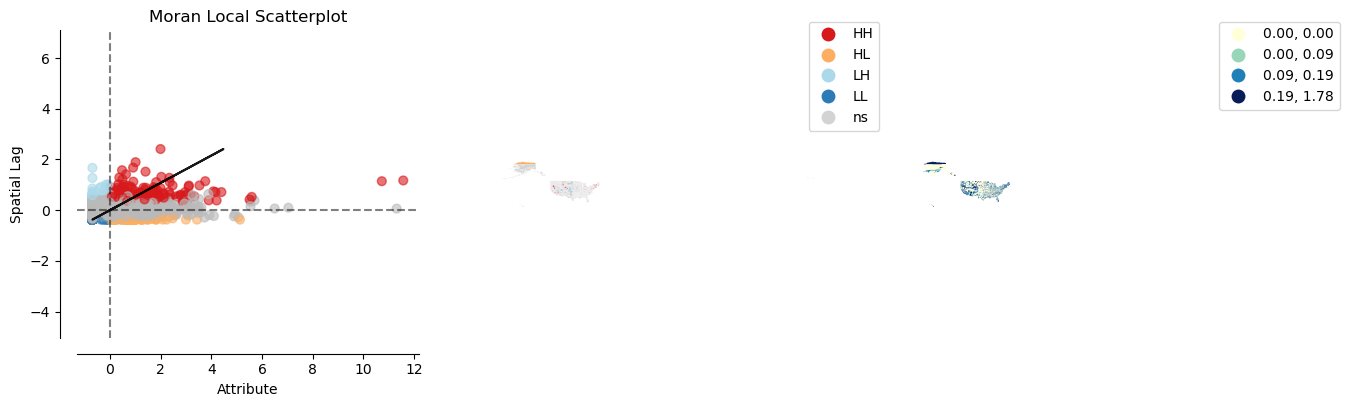

In [124]:
from splot.esda import plot_local_autocorrelation
plot_local_autocorrelation(local_moran, r,'obs_per_1K_fml', p=0.05);

/Users/annafeldman/miniconda3/envs/new_info615/lib/python3.12/site-packages/splot/_viz_esda_mpl.py:354: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sbn.kdeplot(moran.sim, shade=shade, color=color, ax=ax, **kwargs)


(<Figure size 1000x400 with 2 Axes>,
 array([<Axes: title={'center': 'Reference Distribution'}, xlabel='Moran I: -0.0', ylabel='Density'>,
        <Axes: title={'center': 'Moran Scatterplot (-0.0)'}, xlabel='Attribute', ylabel='Spatial Lag'>],
       dtype=object))

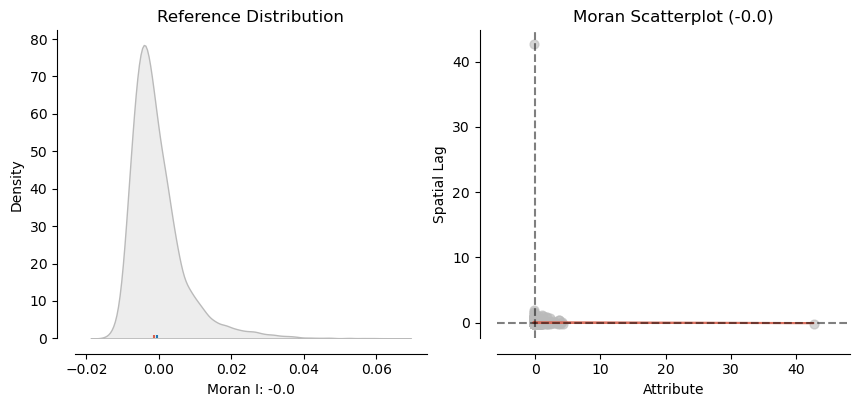

In [125]:
from splot.esda import plot_moran
plot_moran(moran)

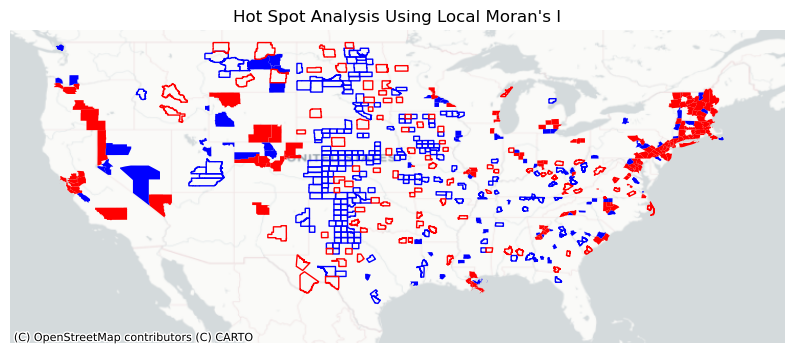

In [127]:
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust figsize as needed
r.plot(ax=ax, facecolor='none', alpha=0)
hotspots.plot(ax=ax, color='red', label="Hot Spot")
coldspots.plot(ax=ax, color='blue', label="Cold Spot")
doughnuts.plot(ax=ax, edgecolor='blue', color='none', label="Doughnuts")
diamonds.plot(ax=ax, edgecolor='red', color='none', label="Diamonds")

#title and labels
plt.title("Hot Spot Analysis Using Local Moran's I")

#set axis limits (x_min, x_max, y_min, y_max)
plt.xlim(-127, -65)
plt.ylim(25, 50)

cx.add_basemap(ax, crs='EPSG:4269', source = cx.providers.CartoDB.Positron)

ax.axis('off');

In [128]:
r = gdf_new
local_moran = esda.moran.Moran_Local(r['total_ob_access_per_1K_fml'], w)

In [129]:
r['local_moran_Is'] = local_moran.Is
r['local_moran_pvalue'] = local_moran.p_sim
r['local_moran_quadrant'] = local_moran.q
alpha = 0.05
hotspots = r.query(f"local_moran_pvalue < {alpha} & local_moran_quadrant == 1")
coldspots = r.query(f"local_moran_pvalue < {alpha} & local_moran_quadrant == 2")
doughnuts = r.query(f"local_moran_pvalue < {alpha} & local_moran_quadrant == 3")
diamonds = r.query(f"local_moran_pvalue < {alpha} & local_moran_quadrant == 4")

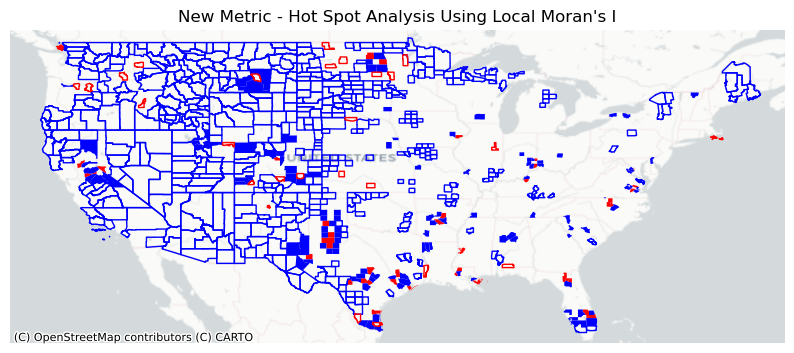

In [130]:
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust figsize as needed
r.plot(ax=ax, facecolor='none', alpha=0)
hotspots.plot(ax=ax, color='red', label="Hot Spot")
coldspots.plot(ax=ax, color='blue', label="Cold Spot")
doughnuts.plot(ax=ax, edgecolor='blue', color='none', label="Doughnuts")
diamonds.plot(ax=ax, edgecolor='red', color='none', label="Diamonds")

#title and labels
plt.title("New Metric - Hot Spot Analysis Using Local Moran's I")

#set axis limits (x_min, x_max, y_min, y_max)
plt.xlim(-127, -65)
plt.ylim(25, 50)

cx.add_basemap(ax, crs='EPSG:4269', source = cx.providers.CartoDB.Positron)

ax.axis('off');

### Export to csv and shapefiles for ArcGIS

In [178]:
#rename variables for shapefile
#df.rename(columns={"A": "a", "B": "c"})
gdf_new = gdf_new.rename(columns={'popn_fem_21': 'fml_pop_21',
                        'md_nf_obgyn_gen_21': 'number_obs', 
                        'obs_per_1K_fml': 'ob_p_1Kfmls',
                        'st_name_abbrev': 'st_abbrv',
                        'obs_per_fml': 'obs_p_fml', 
                        'obs_per_11_births':'obs_11brths', 
                        'obs_per_birth':'obs_p_brths',
                        'peds_per_birth':'peds_p_brth',
                        'births_july_1_june_30_21':'brths_21',
                        'contgs_cnty_num03':'contgs_03',
                        'contgs_cnty_num04':'contgs_04',
                        'contgs_cnty_num05':'contgs_05', 
                        'contgs_cnty_num06':'contgs_06',
                        'contgs_cnty_num07':'contgs_07', 
                        'contgs_cnty_num08':'contgs_08', 
                        'contgs_cnty_num09':'contgs_09',
                        'contgs_cnty_num10':'contgs_10',
                        'contgs_cnty_num11':'contgs_11', 
                        'contgs_cnty_num12':'contgs_12', 
                        'contgs_cnty_num13':'contgs_13', 
                        'contgs_cnty_num14':'contgs_14',
                        'total_ob_access_per_fml':'totl_obs',
                        'total_ob_access_per_1K_fml':'totl_obs1K', 
                        'total_ob_access_per_birth':'totl_obbrts',
                        'total_ob_access_per_11_births':'tot_obs11b',
                        'contig_obs_sum':'cntg_obsum', 
                        'LandArea_SqMiles':'area_sqmi'
                       })
    

In [179]:
#add in new variable showing difference between original and new metric
gdf_new['dif_obnums'] = gdf_new['cntg_obsum'] - gdf_new['number_obs']
gdf_new['dif_ob1Krt'] = gdf_new['totl_obs1K'] - gdf_new['ob_p_1Kfmls']

In [180]:
print(gdf_new.columns.tolist())

['st_name', 'st_abbrv', 'cnty_name', 'cnty_name_st_abbrev', 'fips_st', 'fips_st_cnty', 'fips_cnty', 'cens_regn', 'cens_regn_name', 'cens_divsn', 'cens_divsn_name', 'fed_regn', 'metro_divsn_20', 'metro_divsn_name_20', 'rural_urban_contnm_13', 'urban_influnc_13', 'popn_est_22', 'popn_est_21', 'popn_21', 'popn_mal_21', 'fml_pop_21', 'popn_mal_15_19_20', 'popn_mal_15_19_10', 'popn_fem_15_19_20', 'popn_fem_15_19_10', 'popn_mal_20_24_20', 'popn_mal_20_24_10', 'popn_fem_20_24_20', 'popn_fem_20_24_10', 'popn_mal_25_29_20', 'popn_mal_25_29_10', 'popn_fem_25_29_20', 'popn_fem_25_29_10', 'popn_mal_30_34_20', 'popn_mal_30_34_10', 'popn_fem_30_34_20', 'popn_fem_30_34_10', 'popn_mal_35_44_20', 'popn_mal_35_44_10', 'popn_fem_35_44_20', 'popn_fem_35_44_10', 'medn_age_20', 'medn_age_10', 'medn_age_mal_20', 'medn_age_mal_10', 'medn_age_fem_20', 'medn_age_fem_10', 'number_obs', 'apn_midwvs_npi_21', 'hosp_21', 'stgh_obstetrc_care_21', 'stgh_neonat_icu_21', 'stgh_neonat_interm_care_21', 'stgh_fertlty_clinc

In [181]:
# Export to CSV without geometry column - multipolygon messes it up
gdf_new_nogeometry = gdf_new.drop(columns='geometry')
gdf_new_nogeometry.to_csv('/Users/annafeldman/Desktop/csv_final_output_gdfnew.csv', index=False)

In [182]:
# Export to CSV without geometry column - multipolygon messes it up
#.to_file('output.shp')
gdf_new.to_file('/Users/annafeldman/Desktop/final_output_gdfnew.shp')

/var/folders/sf/whvty1j57cxcxs3t3mhwbcgh0000gn/T/ipykernel_60149/3268327964.py:3: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_new.to_file('/Users/annafeldman/Desktop/final_output_gdfnew.shp')
